Challenge : You are consulting for a real estate company that has a niche in purchasing properties to rent out short-term as part of their business model specifically within New York City. The real estate company has already concluded that two bedroom properties are the most profitable; however, they do not know which zip codes are the best to invest in.

The real estate company has engaged your firm to build out a data product and provide your conclusions to help them understand which zip codes would generate the most profit on short term rentals within New York City.

#### Assumptions

1. The investor will pay for the property in cash (i.e. no mortgage/interest rate will need to be accounted for).
2. The time value of money discount rate is 0% (i.e. $1 today is worth the same 100 years from now).
3. All properties and all square feet within each locale can be assumed to be homogeneous (i.e. a 1000 square foot property in a locale such as Bronx or Manhattan generates twice the revenue and costs twice as much as any other 500 square foot property within that same locale.)
4. The occupancy rate for an year is 75%
5. The properties are rented on Airbnb for the entire year

#### Importing necessary libraries

In [69]:
import os
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Data Available

In [70]:
zillow_file_name = 'Zip_Zhvi_2bedroom.csv'
airbnb_file_name = 'listings.csv.gz'

In [71]:
zillow_costs = pd.read_csv(zillow_file_name, encoding = 'utf-8')
airbnb_rent = pd.read_csv(airbnb_file_name, encoding = 'utf-8')

#### Data Cleaning - Zillow
Zillow provides us an estimate value for two-bedroom properties since 1996 to 2017 for cities across the US

In [72]:
#checking the dimension
zillow_costs.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
1,84654,60657,Chicago,IL,Chicago,Cook,2,167700.0,166400.0,166700.0,...,368600,370200,372300,375300.0,378700,381400,381800,382100,383300,385100
2,61637,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,...,1993500,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300
3,84616,60614,Chicago,IL,Chicago,Cook,4,195800.0,193500.0,192600.0,...,398900,401200,403200,405700.0,408300,408800,408000,410100,412200,412200
4,93144,79936,El Paso,TX,El Paso,El Paso,5,59100.0,60500.0,60900.0,...,82400,82300,82400,82300.0,82500,83200,83900,84100,83900,83700


In [73]:
zillow_costs.shape

(8946, 262)

#### Checking the data for no. of missing values, percentage of missing values, unique values and their date types

In [74]:
def summary(df): 
    '''
    Takes a dataframe and returns a summary of no.of missing values, no.of unique values,percentage of missing values
    and the data types for each column in the dataframe 
    '''
    n = len(df)
    missing_vals = df.isnull().sum()
    missing_vals_percent = round((missing_vals/n)*100, 2)
    unique_vals = df.nunique()
    data_type = df.dtypes
    summary_table = pd.concat([missing_vals, missing_vals_percent, unique_vals, data_type], axis = 1)
    summary_table = summary_table.rename(columns = {0 : 'Missing Values', 1 : '% of Missing Values', 2: 'Unique values', 3: 'Data type'})
    summary_table = summary_table[summary_table.iloc[:,0] != 0].sort_values('% of Missing Values', ascending=False)
    return summary_table

In [75]:
#Calling the above function to get a column wise summary in zillow dataset
summary(zillow_costs)

,Missing Values,% of Missing Values,Unique values,Data type
1996-04,2662,29.76,1581,float64
1996-05,2582,28.86,1567,float64
1996-06,2582,28.86,1564,float64
1996-07,2577,28.81,1564,float64
1996-08,2576,28.79,1570,float64
...,...,...,...,...
2016-02,18,0.20,3492,float64
2016-03,18,0.20,3472,float64
2016-04,18,0.20,3474,float64
2016-05,18,0.20,3532,float64


#### Only columns with median home price have missing values, going as high 30%.

In [76]:
print("Total number of cities :", len(zillow_costs["City"].unique()))

Total number of cities : 4684


In [77]:
#Filter rows corresponding to New York City
zillow_nyc = zillow_costs[(zillow_costs.City == 'New York')]

In [78]:
# create a dataframe where the columns are each zipcode's historical prices
df_nyc = zillow_nyc.iloc[:,7:]
df_nyc.index = zillow_nyc["RegionName"]
df_nyc = df_nyc.T

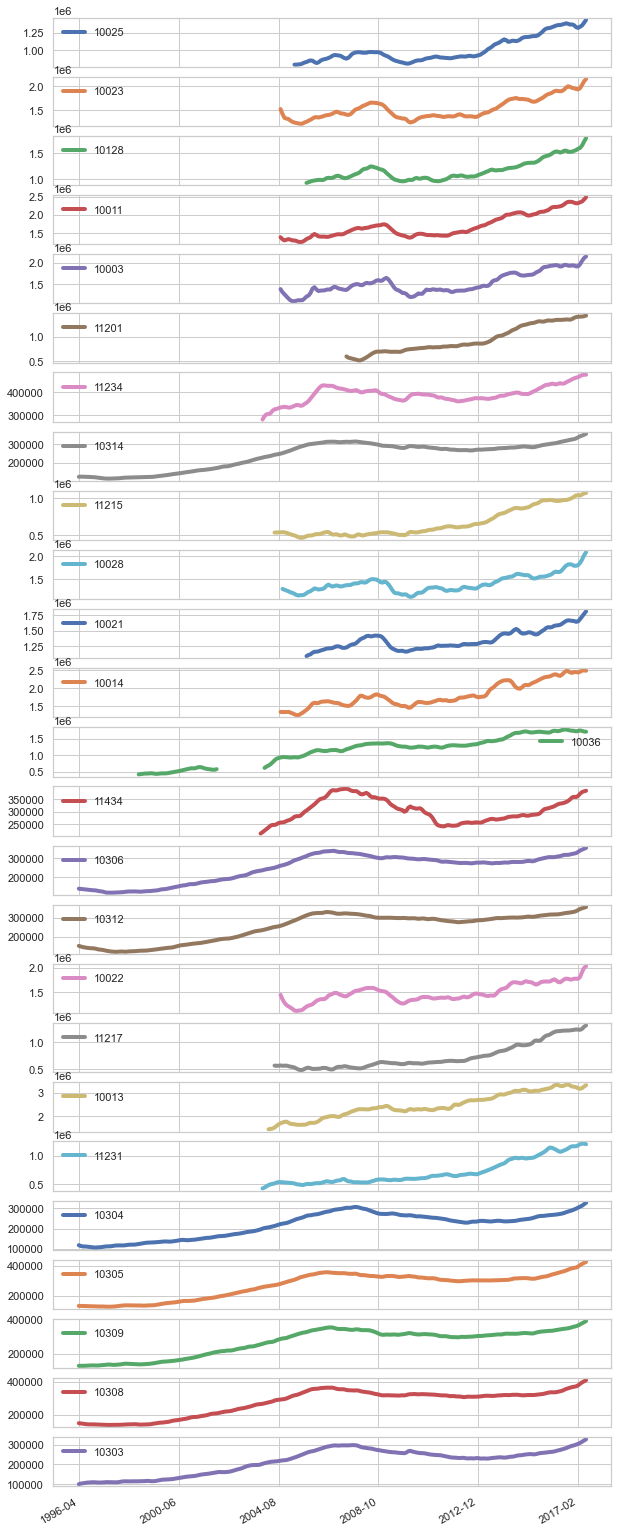

In [79]:
# To see the change in price over time for properties in New York, let's plot the graph below
plot = df_nyc.plot.line(subplots=True, figsize=(10,30), lw=4)

#### From the above plot we can see that the general trend is upwards, except for a major dip in prices in the middle which corresponds to the recession.

In [80]:
#Drop the columns that are not required for our analysis
zillow_nyc = zillow_nyc.drop(columns = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'])

In [81]:
#Unpivot all date columns
zillow_nyc = pd.melt(zillow_nyc, id_vars = ['RegionName'], var_name = 'Year-Month', value_name = 'Median_Price')   

In [82]:
#Separate year and month and drop Year-Month column
zillow_nyc[['Year', 'Month']] = zillow_nyc['Year-Month'].str.split('-', expand = True)
zillow_nyc.drop(columns = ['Year-Month'], inplace=True)     

In [83]:
#Rearrange columns
zillow_nyc = zillow_nyc[['RegionName', 'Year', 'Month', 'Median_Price']]

In [84]:
#Rename RegionName column to zipcode
zillow_nyc = zillow_nyc.rename(columns = {'RegionName': 'zipcode'})
zillow_nyc['zipcode'] = zillow_nyc['zipcode'].astype('int')

In [85]:
#Get the number of unique zip codes present in the New York City dataframe
zillow_nyc['zipcode'].nunique()

25

In [86]:
zillow_nyc.head()

,zipcode,Year,Month,Median_Price
0,10025,1996,04,NaN
1,10023,1996,04,NaN
2,10128,1996,04,NaN
3,10011,1996,04,NaN
4,10003,1996,04,NaN


#### Most of the data before 2007 is missing hence we will focus only on median home values starting from year 2008

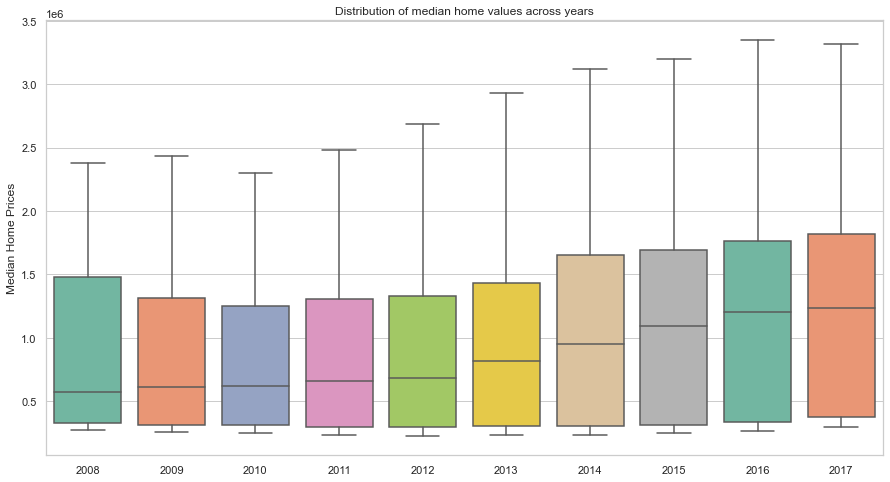

In [89]:
plt.figure(figsize=(15,8))
_ = sns.boxplot(x = 'Year', y = 'Median_Price', data = zillow_nyc[zillow_nyc['Year'] >= '2008'], palette = 'Set2')
_ = plt.xlabel("")
_ = plt.ylabel("Median Home Prices")
_ = plt.title("Distribution of median home values across years")

In [20]:
#Representing each year(starting 2008) with its corresponding median value
zillow_nyc_price = zillow_nyc.groupby(['zipcode', 'Year'])['Median_Price'].median().reset_index()
zillow_nyc_price = zillow_nyc_price.loc[zillow_nyc_price['Year'] >= '2008']
zillow_nyc_price.to_csv('median_price.csv')


Now that we have a single home value for each year, let us look at how the median home values have fared during:

1. During the 7 year period between 2011 and 2017
2. During the 3 year period between 2015 and 2017

In [21]:
#Style
plt.style.use('seaborn-darkgrid')
#Create a color palette
palette = plt.get_cmap('Set2')
#Defining a function to return the required area plots
def area_plot(df, category, x_axis, y_axis, start_year, end_year):
    data = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]
    g = sns.FacetGrid(data, col=category, hue=category, col_wrap=5)
    g = g.map(sns.scatterplot, x_axis, y_axis)
    g = g.map(plt.fill_between, x_axis, y_axis, alpha=0.2)
    g = g.set_titles('Median home values')
    g = g.add_legend()
    plt.subplots_adjust(top=0.92)
    plt.show()

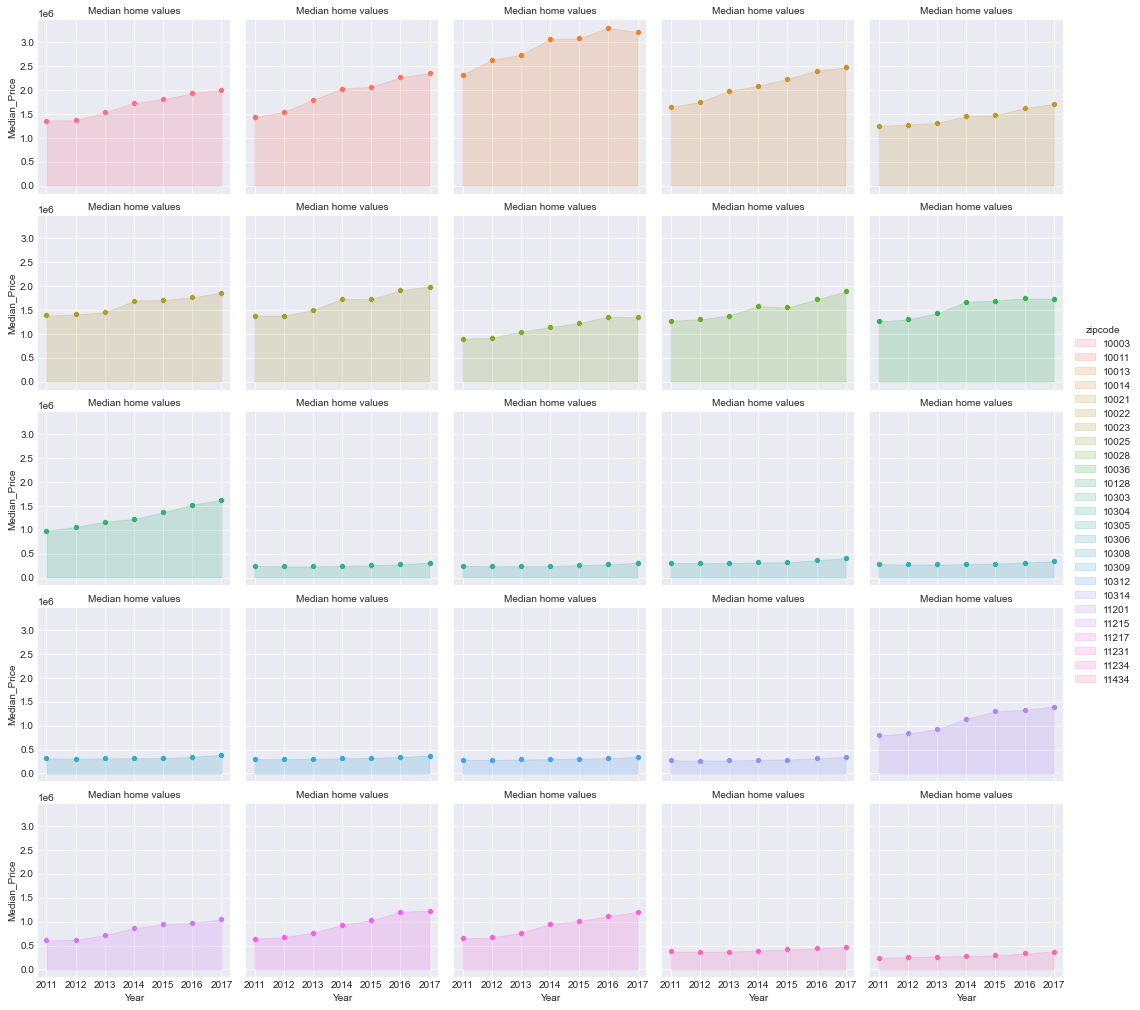

In [22]:
#Calling the above function to get area plots for median prices between 2011 and 2017
area_plot(zillow_nyc_price, 'zipcode', 'Year', 'Median_Price', '2011', '2017')

We can see that some zipcodes have experienced a substantial rise in home values (10003, 10011, 10013, 10014). However, it seems that during the last 3 years, home values have remained fairly constant. We can see this more clearly in the plot below

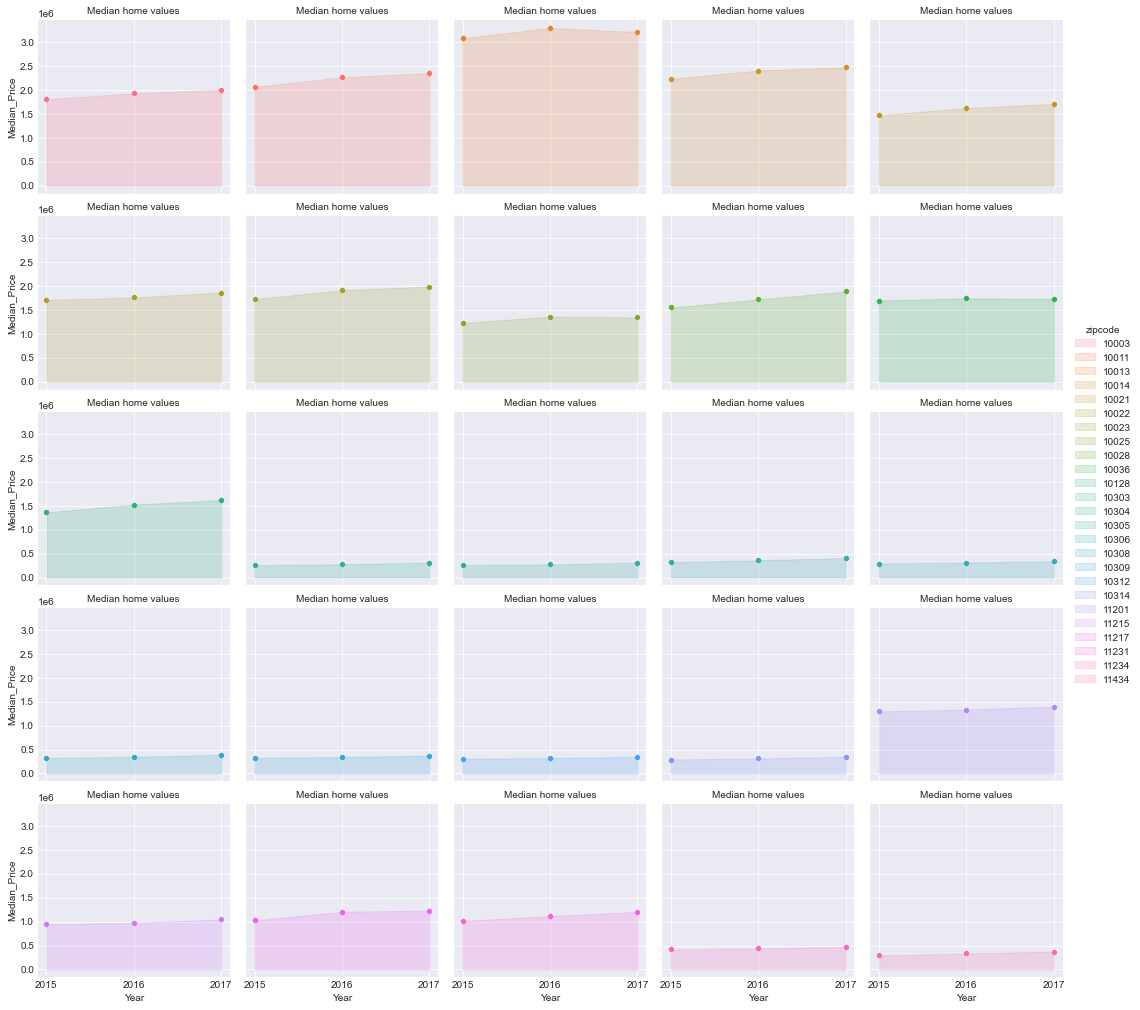

In [23]:
area_plot(zillow_nyc_price, 'zipcode', 'Year', 'Median_Price', '2015', '2017')

#### From the above plot, it can be observed that median house prices for NYC zip codes have remained fairly constant between the period 2015 and 2017

To resolve the issue of inconsistent units of time between the Zillow and Airbnb datasets, we can use a time series forecasting model such as ARIMA to predict the house values in 2019. However, predicted values for almost 2 years ahead could give inaccurate results.Therefore, to reduce complexity, and based on the plot above, we will assume that the house values in each zipcode remain the same as they were in 2017. Going forward, we compute our metrics based on this assumption.

Transforming our NYC price dataframe to show a single price per RegionName (zip code), that is the 2017-06 price

In [24]:
zillow_nyc_price = zillow_nyc_price.loc[zillow_nyc_price['Year'] == '2017'].drop('Year', axis = 1)

#### Data Cleaning - Airbnb
AirBnB is the medium through which the investor plans to lease out their investment property.

In [25]:
airbnb_rent.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2539,https://www.airbnb.com/rooms/2539,20190708031610,2019-07-09,Clean & quiet apt home by the park,Renovated apt home in elevator building.,"Spacious, renovated, and clean apt home, one b...",Renovated apt home in elevator building. Spaci...,none,Close to Prospect Park and Historic Ditmas Park,...,f,f,moderate,f,f,6,0,5,1,0.21
1,2595,https://www.airbnb.com/rooms/2595,20190708031610,2019-07-09,Skylit Midtown Castle,"Find your romantic getaway to this beautiful, ...","- Spacious (500+ft²), immaculate and nicely fu...","Find your romantic getaway to this beautiful, ...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,2,1,0,1,0.38
2,3647,https://www.airbnb.com/rooms/3647,20190708031610,2019-07-08,THE VILLAGE OF HARLEM....NEW YORK !,NaN,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,WELCOME TO OUR INTERNATIONAL URBAN COMMUNITY T...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
3,3831,https://www.airbnb.com/rooms/3831,20190708031610,2019-07-09,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.64
4,5022,https://www.airbnb.com/rooms/5022,20190708031610,2019-07-08,Entire Apt: Spacious Studio/Loft by central park,NaN,Loft apartment with high ceiling and wood floo...,Loft apartment with high ceiling and wood floo...,none,NaN,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.10


In [26]:
airbnb_rent.shape

(48895, 106)

In [27]:
# Looking at a summary of columns with no. of missing values, percentage of missing values, unique values and their date types
summary(airbnb_rent)

,Missing Values,% of Missing Values,Unique values,Data type
thumbnail_url,48895,100.00,0,float64
medium_url,48895,100.00,0,float64
host_acceptance_rate,48895,100.00,0,float64
xl_picture_url,48895,100.00,0,float64
jurisdiction_names,48882,99.97,5,object
license,48874,99.96,9,object
square_feet,48487,99.17,97,float64
monthly_price,43647,89.27,680,object
weekly_price,42891,87.72,598,object
notes,28704,58.71,17016,object


#### The airbnb dataset has a lot of missing values with some columns having 100% null-values. We can also see that the zipcode column has 517 missing values. Since we will join the Zillow and Airbnb datasets, we need to find a way to impute these values.

In [28]:
#Remove columns with more than 50% null values
airbnb_rent = airbnb_rent.dropna(thresh = 0.50 * len(airbnb_rent), axis = 1)
#Filter and keep rows that correspond to 2 bedroom properties
airbnb_rent = airbnb_rent[airbnb_rent['bedrooms'] == 2] 

In [29]:
#cleaning the price column by removing'$' and ',' from the price column values and storing them as float type
airbnb_rent['price'] = airbnb_rent['price'].apply(str).str.replace('$', '')
airbnb_rent['price'] = airbnb_rent['price'].apply(str).str.replace(',', '')
airbnb_rent['price'] = airbnb_rent['price'].astype('float')  

In [30]:
#Find and remove columns that will not be useful for determining the profitability of a zip code, i.e. metadata for
#properties & hosts and columns that are used by Airbnb as internal identifiers
columns_to_remove = []
for column in airbnb_rent.columns:
    if column.startswith(("host", "require")):
        columns_to_remove.append(column)
    elif column.endswith(("url", "nights")):
        columns_to_remove.append(column)
airbnb_rent = airbnb_rent[airbnb_rent.columns[~airbnb_rent.columns.isin(columns_to_remove)]]

Text(0.5, 1.0, 'Neighbourhood cleansed')

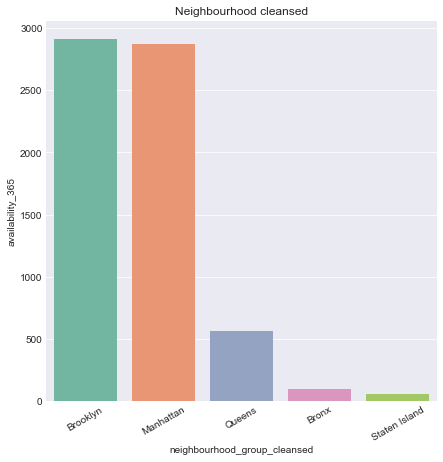

In [31]:
#Plotting the availability of airbnb throughout the year within each neighbourhood
plt.figure(figsize=(7,7))
neighbourhood_group_cleansed_df = airbnb_rent.groupby('neighbourhood_group_cleansed').count()[['availability_365']].sort_values(by='availability_365',ascending=False).head(5)
bar =  sns.barplot(x=neighbourhood_group_cleansed_df.index, y=neighbourhood_group_cleansed_df.availability_365, palette = 'Set2')
bar.set_xticklabels(bar.get_xticklabels(), rotation=30)
plt.title("Neighbourhood cleansed")

From the above graph we can see that Brooklyn and Manhattan have the highest availability throughout the year

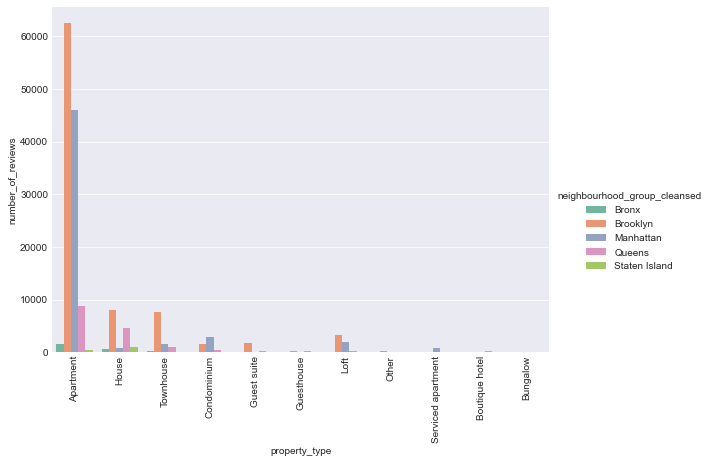

In [32]:
#Plotting customer reviews for each property type
number_of_reviews_df = airbnb_rent.groupby(['neighbourhood_group_cleansed','property_type']).agg({'number_of_reviews':'sum'}).reset_index()
number_of_reviews_df = number_of_reviews_df[number_of_reviews_df['number_of_reviews']>100]
ax = sns.catplot(x="property_type", y="number_of_reviews", hue="neighbourhood_group_cleansed", kind="bar", 
                 data=number_of_reviews_df,height=5.27, aspect=10.7/7.27,palette = 'Set2' );
ax.set_xticklabels(rotation=90)

#### From the customer reviews we can see that in Brooklyn and Manhattan two bedroom apartment and House are the most reviewed and popular. Queens and Staten Island as well show closely similar trends.

In [33]:
#Drop columns that contain significant null values and not considered for our analysis 
cols_to_drop_manual = ['id', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered',
                      'notes', 'access', 'interaction', 'house_rules', 'is_location_exact', 'amenities', 'security_deposit',
                      'cleaning_fee', 'guests_included', 'extra_people', 'calendar_updated', 'calendar_last_scraped',
                      'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                       'review_scores_communication', 'requires license', 'license', 'jurisdiction_names',
                       'instant_bookable', 'cancellation_policy', 'calculated_host_listings_count']
airbnb_rent = airbnb_rent[airbnb_rent.columns[~airbnb_rent.columns.isin(cols_to_drop_manual)]]

In [34]:
#Get a list of unique neighbourhoods in our dataset
list_of_neighbourhoods = list(airbnb_rent['neighbourhood_group_cleansed'].unique())
list_of_neighbourhoods

['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

Text(0.5, 1.0, 'Number of listings in each neighbourhood group')

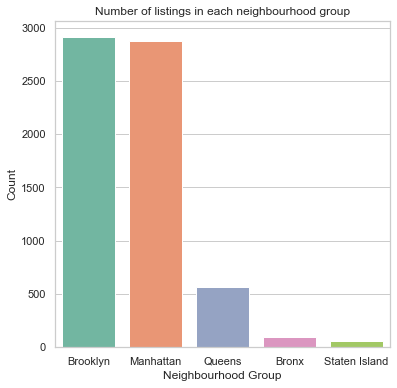

In [35]:
#Popular neighbourhood groups based on number and density of listings
sns.set(style="whitegrid")
plt.figure(figsize=(6,6))
df=airbnb_rent.neighbourhood_group_cleansed.value_counts(ascending=False).to_frame().reset_index()
ax = sns.barplot(x="index", y="neighbourhood_group_cleansed", data=df, palette = 'Set2')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Count')
plt.title("Number of listings in each neighbourhood group")

#### We see that Manhattan and Brookyln neighbourhood groups have the highest number of two bedroom listings while Queens, Bronx and Staten Island have relatively lesser number of listings. The higher number of listings can be explained by higher popularity or larger size of the neighbourhood group.

### Relative density of neighbourhood groups 

In [36]:
zipcodes_each_neigh=airbnb_rent.groupby(['neighbourhood_group_cleansed','zipcode'])['zipcode'].count().to_frame()
zipcodes_each_neigh=zipcodes_each_neigh.groupby('neighbourhood_group_cleansed').count().reset_index()
zipcodes_each_neigh.columns = ['neighbourhood_group_cleansed','value']
zipcodes_each_neigh=zipcodes_each_neigh.set_index('neighbourhood_group_cleansed')

Text(0.5, 1.0, 'Density of listings in each neighbourhood group')

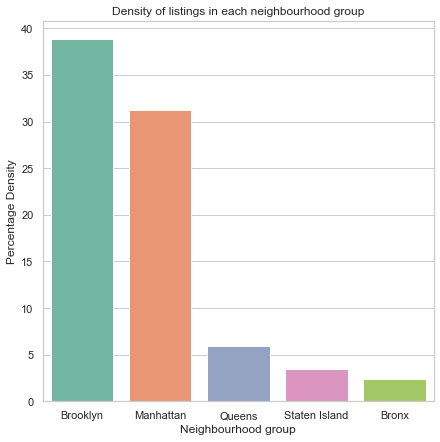

In [37]:
total_listings=airbnb_rent.neighbourhood_group_cleansed.value_counts(ascending=False).to_frame().reset_index()
total_listings.columns = ['neighbourhood_group_cleansed','value']
total_listings=total_listings.set_index('neighbourhood_group_cleansed')

sns.set(style="whitegrid")
plt.figure(figsize=(7,7))
df=(total_listings/zipcodes_each_neigh).sort_values(by='value',ascending=False).reset_index()
ax = sns.barplot(x="neighbourhood_group_cleansed", y="value", data=df, palette = 'Set2')
plt.xlabel('Neighbourhood group')
plt.ylabel('Percentage Density')
plt.title("Density of listings in each neighbourhood group")

#### From the above barplot, we can see that Manhattan and Brooklyn are highly dense with two-bedroom airbnb properties while Queens and Staten Island have less number of properties in them.

We can infer that Manhattan and Brookyln must be popular areas to have airbnb properties in because of a high density of listings in each zipcode and because of the high number of listings, these properties must be booked quite frequently and are established neighbourhoods.

On the other hand, Queens and Staten Island are less dense. We can assume that these neighbourhoods are unsaturated and have the most potential to establish new

### Top popular neighbourhoods based on number of listings

Text(0.5, 1.0, 'Top popular neighbourhoods based on number of listings')

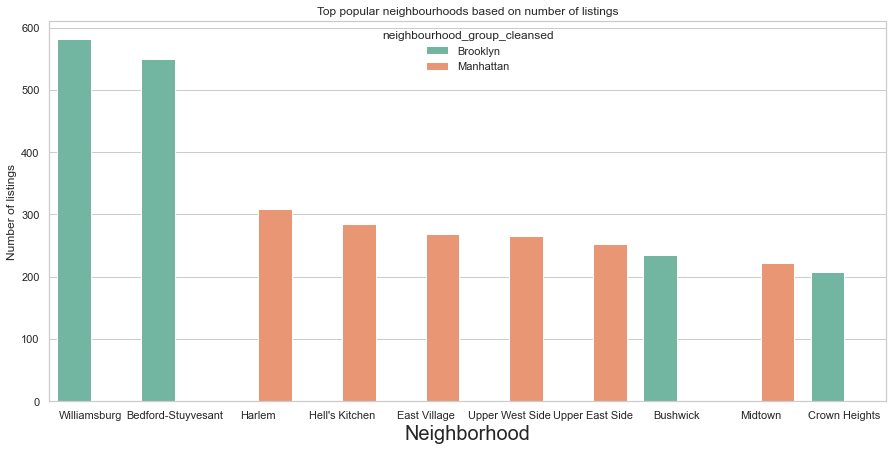

In [38]:
df=airbnb_rent.groupby(['neighbourhood_group_cleansed','neighbourhood_cleansed'])['neighbourhood_cleansed'].agg(
    count='count').sort_values(by='count',ascending=False).reset_index()[:10].reset_index()
plt.figure(figsize=(15,7))
ax = sns.barplot(x="neighbourhood_cleansed", y="count",data=df,palette = 'Set2', hue='neighbourhood_group_cleansed')
plt.xlabel('Neighborhood', fontsize=20)
plt.ylabel('Number of listings')
plt.title("Top popular neighbourhoods based on number of listings")

#### Williamsburg, Bedford-Stuyvesant and Harlem properties have the highest number of properties which mean they must be really popular. We can see that the popular neighbourhoods belong to Brooklyn and Manhattan as indicated in the above plot. Hell's Kitchen is the next most popular neighbourhood belonging to Manhattan

Text(0, 0.5, 'Percentage')

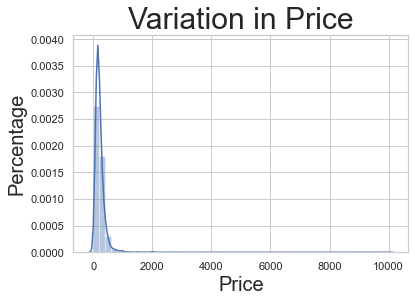

In [39]:
#Plotting variation in price
ax = sns.distplot(airbnb_rent['price'])
ax.axes.set_title("Variation in Price",fontsize=30)

plt.xlabel('Price', fontsize=20)
plt.ylabel('Percentage', fontsize=20)

#### From the above plot, we can infer that most of the values lie below 600usd and its right-skewed. There are a lot of outliers with the maximum price value being 4000usd. From this plot, we can conclude that we shall need to handle the outliers well since it can skew results by huge margins.
We shall be using median instead of mean for further analysis due to presence of large outliers.

### Median price for a 2-bedroom property by neighbourhood

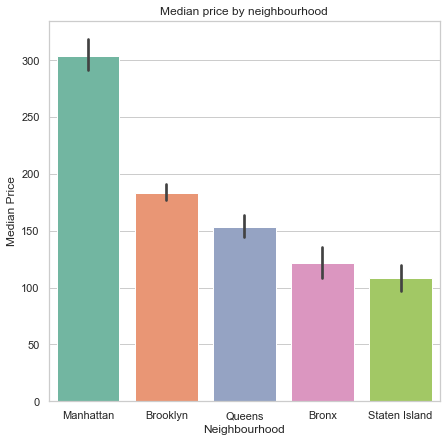

In [40]:
sns.set(style="whitegrid")
df=airbnb_rent.groupby('neighbourhood_group_cleansed')['price'].median().sort_values(ascending=False).to_frame().reset_index()
df
plt.figure(figsize=(7,7))
_ = sns.barplot(x = 'neighbourhood_group_cleansed', y = 'price',data = airbnb_rent, palette = 'Set2')
_ = plt.xlabel("Neighbourhood")
_ = plt.ylabel("Median Price")
_ = plt.title("Median price by neighbourhood")

#### The Median price of Manhattan listings are 300usd per night and Brooklyn listings are 180usd per night.
We conclude that the higher median price can be associated with higher popularity, higher density of listings and higher bookings. The higher median price could also mean a larger area of the listings attracting higher price which we shall determine in the next section

The Median price of Queens listings are 150usd per night, Bronx 130usd and  Staten Island listings are 110usd per night. We conclude that Queens, Bronx and  Staten Island have less popularity and less density of listings. The less median price can also confirm that bookings must not be as frequent since the prices are low to attract more customers.

### Median price by room_type

Text(0, 0.5, 'Median Price')

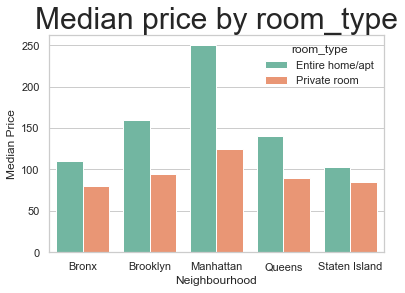

In [41]:
df=airbnb_rent.groupby(['neighbourhood_group_cleansed','room_type']).price.agg(Median_price='median').reset_index()
ax=sns.barplot(x="neighbourhood_group_cleansed", y="Median_price", hue="room_type", data=df, palette = 'Set2')
ax.axes.set_title("Median price by room_type",fontsize=30)
plt.xlabel('Neighbourhood')
plt.ylabel('Median Price')

#### We conclude that most of the listings in Manhattan are for entire home/apts which account for the high price. The price is more than 2x as that for private rooms.
Brookyln and Queens also have high price for entire home/apts as compared to private rooms. However, this difference is not as large as that of Manhattan listings.
Private rooms in all four neighbourhood groups have similar price which is surprising given the popularity difference between the neighbourhoods and the distinct difference in median prices for entire home/apts.¶

In [42]:
#Iterate over all neighbourhoods to generate a dictionary with neighbourhood as key and respective zipcode modes as values
most_frequent_zipcodes = {}
for neighbour in list_of_neighbourhoods:
    value = airbnb_rent.loc[airbnb_rent['neighbourhood_group_cleansed'] == neighbour, 'zipcode'].mode()[0]
    most_frequent_zipcodes[neighbour] = value
most_frequent_zipcodes

{'Manhattan': '10009',
 'Brooklyn': '11211',
 'Queens': '11385',
 'Bronx': '10451',
 'Staten Island': '10301'}

In [43]:
airbnb_rent['zipcode'].unique()

array(['10029', '11221', '11206', '10001', '10162', '11215', '10075',
       '11211', '10031', '10002', '11217', '11231', '11233', '10009',
       '10023', '11201', '11238', '11249', '10027', '10039', '11385',
       '10013', '10011', '11222', '11216', '10032', '11205', '10003',
       '10012', '10026', '10025', '10128', '10014', '11104', '10022',
       '11225', '11101', '10038', '11213', '11106', '10016', '10036',
       '10463', '10065', '10024', '10455', '10034', '11237', '10469',
       '11235', '10314', '10452', '11103', '11220', '10004', '11226',
       '10282', '10019', '11377', '10033', '10021', '11230', '11214',
       '10037', '10010', '11418', '10030', '10005', '10035', '11218',
       '11105', '11372', nan, '11207', '10028', '10017', '11208', '10040',
       '11412', '11367', '11374', '11209', '11693', '10305', '11109',
       '10304', '11102', '11212', '11232', '11204', '10451', '11369',
       '11234', '10473', '10301', '10044', '10018', '11236', '11203',
       '11373',

In [44]:
#Map dictionary values to NaN values in zipcode column
airbnb_rent['zipcode'] = airbnb_rent['zipcode'].fillna(airbnb_rent['neighbourhood_group_cleansed'].map(most_frequent_zipcodes))

In [45]:
#Confirm that all missing values in zipcode column have been imputed
(airbnb_rent['zipcode'].isnull().sum())

0

In [46]:
#Convert 'zipcode' column to int
airbnb_rent['zipcode'] = airbnb_rent['zipcode'].astype('int')

In [47]:
#List of neighbourhood and zipcodes belonging to them¶
neighbourhood_max_zipcode=airbnb_rent.groupby(['neighbourhood_group_cleansed','zipcode'])['zipcode'].agg(total_count='count').reset_index()
neighbourhood_max_zipcode.T

,0,1,2,3,4,5,6,7,8,9,...,162,163,164,165,166,167,168,169,170,171
neighbourhood_group_cleansed,Bronx,Bronx,Bronx,Bronx,Bronx,Bronx,Bronx,Bronx,Bronx,Bronx,...,Staten Island,Staten Island,Staten Island,Staten Island,Staten Island,Staten Island,Staten Island,Staten Island,Staten Island,Staten Island
zipcode,10451,10452,10453,10454,10455,10456,10457,10458,10459,10460,...,10301,10303,10304,10305,10306,10307,10308,10309,10310,10314
total_count,11,5,1,7,3,5,2,3,4,2,...,24,4,3,12,2,1,2,1,5,2


In [48]:
#Maximum occuring zipcode for each neighbourhood (this maynot be a useful information - probably can skip this)
neighbourhood_zipcode_df=neighbourhood_max_zipcode.groupby('neighbourhood_group_cleansed').apply(lambda x: x.zipcode[x.total_count.idxmax()]).to_frame().reset_index()
neighbourhood_zipcode_df.columns=['neighbourhood_cleansed','zipcode']
neighbourhood_zipcode_df.T

,0,1,2,3,4
neighbourhood_cleansed,Bronx,Brooklyn,Manhattan,Queens,Staten Island
zipcode,10451,11211,10009,11385,10301


In [49]:
neighbourhood_zipcode_df
neighbourhood_max_zipcode

,neighbourhood_group_cleansed,zipcode,total_count
0,Bronx,10451,11
1,Bronx,10452,5
2,Bronx,10453,1
3,Bronx,10454,7
4,Bronx,10455,3
...,...,...,...
167,Staten Island,10307,1
168,Staten Island,10308,2
169,Staten Island,10309,1
170,Staten Island,10310,5


In [50]:
apartment_list = ["Apartment", "House", "Townhouse", "Loft", "Condominium", "Serviced apartment"]
def populate_property_agg(v):
    if v not in apartment_list:
        return 'Other'
    return v

airbnb_rent['property_agg'] = airbnb_rent["property_type"].apply(populate_property_agg)
airbnb_rent['property_agg'].value_counts()

Apartment             5076
House                  400
Condominium            343
Loft                   247
Townhouse              237
Other                  116
Serviced apartment      78
Name: property_agg, dtype: int64

In [51]:
airbnb_rent["room_type"].value_counts()

Entire home/apt    5933
Private room        564
Name: room_type, dtype: int64

### Joining the Zillow and Airbnb datasets
We now join the Zillow and Airbnb datasets. We will use an inner join on zipcode column to accomplish this. This will ensure that we will only have those zipcodes in our combined dataset that are present in the both Zillow and Airbnb datasets

In [52]:
#Join zillow and airbnb datasets on the zipcode column
df_merge = pd.merge(left = airbnb_rent, right = zillow_nyc_price, left_on = 'zipcode', right_on = 'zipcode')
df_merge.head()

,neighborhood_overview,transit,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,...,review_scores_rating,review_scores_location,review_scores_value,is_business_travel_ready,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,property_agg,Median_Price
0,"We are in the heart of Park Slope, a truly bea...",We are a 5-7 minute walk to the Union Street R...,"Brooklyn, NY, United States",Brooklyn,Park Slope,Brooklyn,Brooklyn,NY,11215,New York,...,100.0,10.0,10.0,f,1,0,0,0.16,Condominium,1045400.0
1,NaN,NaN,"Brooklyn, NY, United States",Brooklyn,South Slope,Brooklyn,Brooklyn,NY,11215,New York,...,95.0,10.0,10.0,f,2,0,0,0.24,Apartment,1045400.0
2,Great for families and friends. Close to bouti...,"The F, G and R trains are only 5 minutes away ...","Brooklyn, NY, United States",Gowanus,Gowanus,Brooklyn,Brooklyn,NY,11215,New York,...,94.0,10.0,9.0,f,1,0,0,2.17,Loft,1045400.0
3,Quiet tree-lined street Two shopping/restauran...,On street parking. Also parking garage 4 block...,"Brooklyn, NY, United States",Park Slope,Windsor Terrace,Brooklyn,Brooklyn,NY,11215,New York,...,97.0,10.0,10.0,f,0,1,0,0.26,Townhouse,1045400.0
4,Park Slope is considered one of New York City'...,"The F, G and R train are a 5-minute walk takin...","Brooklyn, NY, United States",Park Slope,South Slope,Brooklyn,Brooklyn,NY,11215,New York,...,97.0,10.0,10.0,f,2,1,0,3.97,Apartment,1045400.0


#### We will try to identify if certain zipcodes consistently receive better review scores for location (review_scores_location) compared to others. If there exists a clear distinction between zipcodes, the review scores feature could help us identify which zipcodes are preferred in terms of their location

In [53]:
#Convert zipcode column to category type to make plotting easier
df_merge['zipcode'] = df_merge['zipcode'].astype('category')

#### We will need to normalize the review_scores_location column by the number of reviews each zipcode has received since there is some imbalance in the number of reviews received by each zipcode

In [54]:
#Calculate the sum of review scores received by each zipcode
review_score_plot = df_merge.groupby('zipcode')['review_scores_location'].sum().reset_index()

#Calculate the number of review scores received by each zipcode
review_score_plot_count = df_merge.groupby('zipcode')['review_scores_location'].count().reset_index()

#Combine the above dataframes
review_score_plot = pd.merge(left = review_score_plot, right = review_score_plot_count, left_on = 'zipcode', right_on = 'zipcode')

#Rename the columns
review_score_plot.columns = ['zipcode', 'review_scores_sum', 'review_scores_count']

#Calculate normalized scores
review_score_plot['normalized_review_scores'] = review_score_plot['review_scores_sum']/review_score_plot['review_scores_count']

In [55]:
review_score_plot.head(2)

,zipcode,review_scores_sum,review_scores_count,normalized_review_scores
0,10003,932.0,95,9.810526
1,10011,795.0,80,9.937500


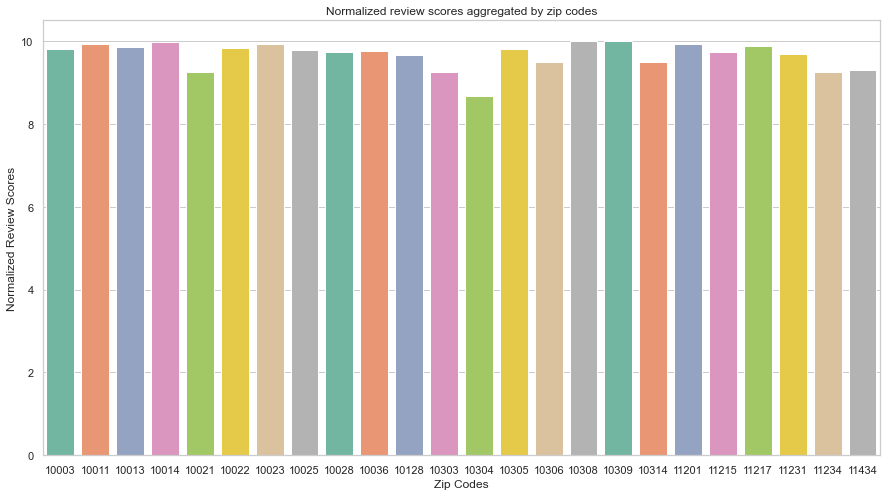

In [56]:
#Plot normalized review scores against each zipcode
plt.figure(figsize=(15,8))
_ = sns.barplot(x = 'zipcode', y = 'normalized_review_scores', data = review_score_plot, palette = 'Set2')
_ = plt.xlabel("Zip Codes")
_ = plt.ylabel("Normalized Review Scores")
_ = plt.title("Normalized review scores aggregated by zip codes")

#### We cannot see a substantial difference in the review scores received by each zip code. All of them have received pretty good scores. The hypothesized metric, based on review_scores_location should not be used for identifying profitable zipcodes

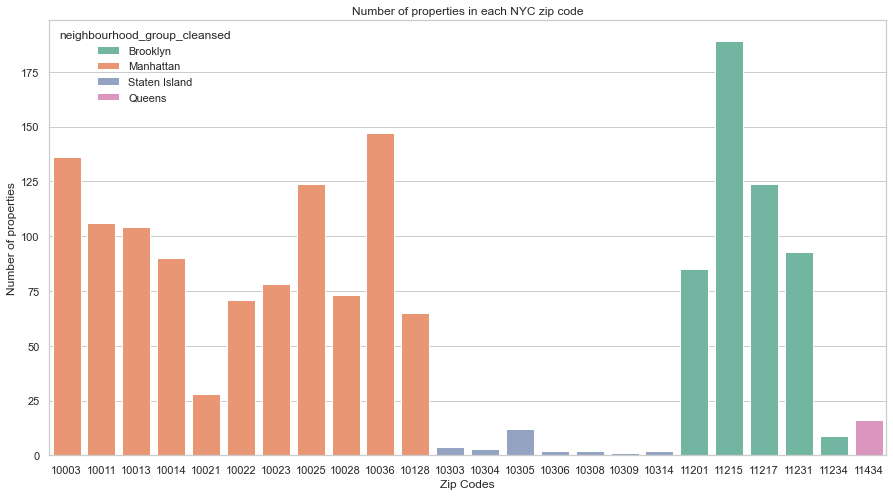

In [57]:
#Demand for properties across zipcodes 
plt.figure(figsize=(15,8))
_ = sns.countplot(x = 'zipcode', data = df_merge, dodge = False, palette = 'Set2', hue = 'neighbourhood_group_cleansed')
_ = plt.xlabel("Zip Codes")
_ = plt.ylabel("Number of properties")
_ = plt.title("Number of properties in each NYC zip code")

#### As seen from the plot, zipcodes in Manhattan and Brooklyn should be favoured since it seems these areas currently have a considerably higher number of properties compared to Queens and Staten Island. This could be to cater the high demand for rentals in Manhattan and Brooklyn However, we should also look at a caveat here. More properties also inherently means more competition since a customer has more choices to pick from in a particular neighbourhood. This is something that can be looked at as a future consideration

### Number of reviews received

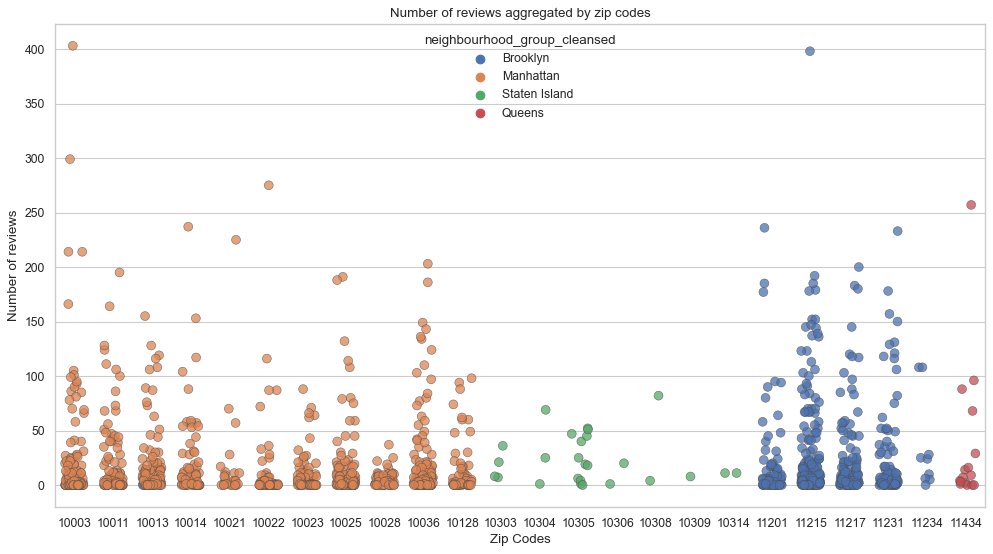

In [58]:
fig, ax = plt.subplots(figsize=(15,8), dpi= 80)    
sns.stripplot(df_merge['zipcode'], df_merge['number_of_reviews'], hue = df_merge['neighbourhood_group_cleansed'],
              jitter=0.25, size=8, alpha = 0.75, edgecolor= 'gray', ax=ax, linewidth=.5)
_ = plt.xlabel("Zip Codes")
_ = plt.ylabel("Number of reviews")
_ = plt.title("Number of reviews aggregated by zip codes")

#### Distribution of rental price per night across neighbourhoods
In this section, we take a look at how the per night rental price is distributed across each neighbourhood

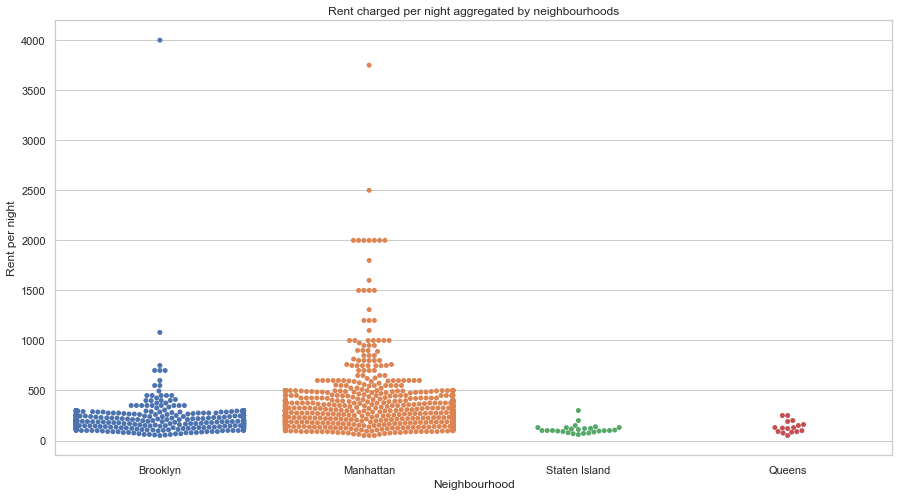

In [59]:
plt.figure(figsize=(15,8))
_ = sns.swarmplot(x="neighbourhood_group_cleansed", y="price", data=df_merge)
_ = plt.xlabel("Neighbourhood")
_ = plt.ylabel("Rent per night")
_ = plt.title("Rent charged per night aggregated by neighbourhoods")

It can be seen from the plot that rental properties in Manhattan garner a relatively higher rent per night for 2 bedroom properties. Properties in Brooklyn also seem favourable on this critera. However, we need to look at the distribution of home prices in the neighbourhoods as well to assess how early can the investor break-even

It can be seen that overall properties in Manhattan and Brooklyn have received more reviews (some receiving as high as ~400).

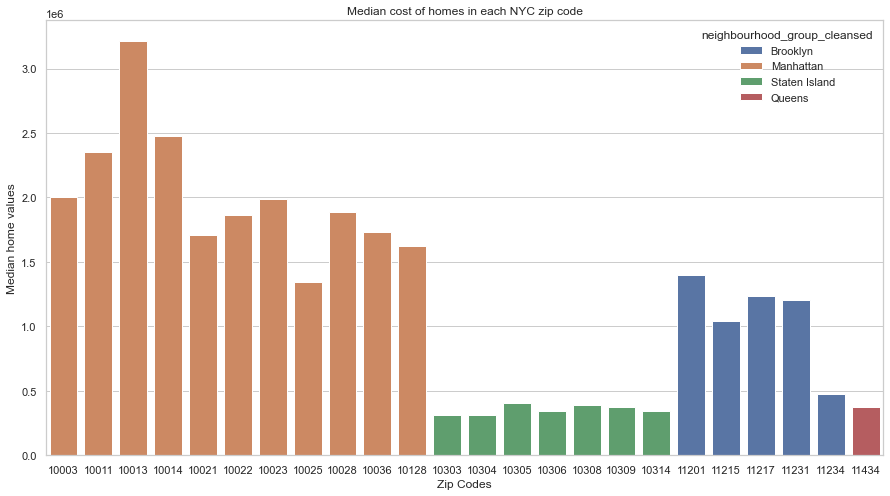

In [60]:
plt.figure(figsize=(15,8))
_ = sns.barplot(x = 'zipcode', y = 'Median_Price', hue = 'neighbourhood_group_cleansed', data = df_merge, dodge = False)
_ = plt.xlabel("Zip Codes")
_ = plt.ylabel("Median home values")
_ = plt.title("Median cost of homes in each NYC zip code")

#### The plots above suggest that although one can expect higher to earn higher rent per night in Manhattan and Brooklyn areas, the cost of homes is also higher in these neighbourhoods. We will calculate the % annual return on investment to get a clear picture of how the returns will be compared to the investment made

#### How far ahead are properties booked in each zip code

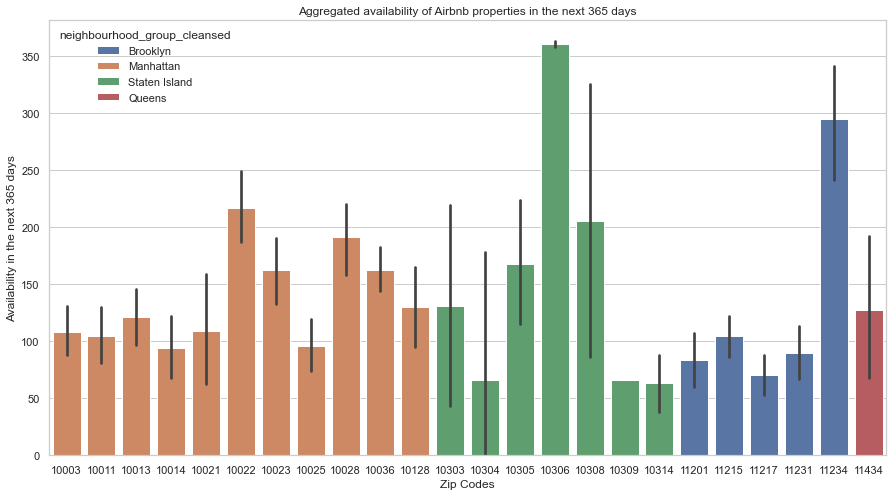

In [61]:
plt.figure(figsize=(15,8))
_ = sns.barplot(x = 'zipcode', y = 'availability_365', hue = 'neighbourhood_group_cleansed', data = df_merge, dodge = False)
_ = plt.xlabel("Zip Codes")
_ = plt.ylabel("Availability in the next 365 days")
_ = plt.title("Aggregated availability of Airbnb properties in the next 365 days")

#### The plot above shows that properties in Staten Island are booked in advance, since their availability in the next 365 days is less this could mean that properties in these zipcodes are generally in demand.

### Calculate price assuming 75% occupancy

In [62]:
airbnb_breakeven_df=df_merge[['zipcode','neighbourhood_group_cleansed','price','Median_Price']]
airbnb_75_occ_df=airbnb_breakeven_df.groupby(['zipcode','neighbourhood_group_cleansed'])['price'].median()
airbnb_75_occ_df=(airbnb_75_occ_df*.75).reset_index()
airbnb_zipcode_neighbourhood_df=airbnb_75_occ_df[['zipcode','neighbourhood_group_cleansed']]
airbnb_zipcode_neighbourhood_df.to_csv('airbnb_zipcode_neighbourhood_df.csv')

In [63]:
def get_price_75(each_zipcode):
    zipcode=int(each_zipcode)
    return(airbnb_75_occ_df[airbnb_75_occ_df.zipcode==(zipcode)]['price'].median())

#Dataframe with zipcode,neighbourhood,median_price,median_price_75,median_cost
airbnb_breakeven_df['price_75']=airbnb_breakeven_df.zipcode.apply(get_price_75)

### Calculate breakeven in number of years for each zipcode

Assumptions made in calculating breakeven years: 
1. All fixed costs remain the same for all listings for all years 
2. Current price remains fixed 
3. Cost from 2017 used for calculating median cost

Formula Used
1. Revenue = ( Price0.75 ) * 365 
2. Breakeven Years = Median Cost / Revenue 

In [64]:
def find_breakeven_years(each_row):
    years=each_row.Median_Price/each_row.price_75
    years=years/365
    return years

airbnb_breakeven_df['years']=airbnb_breakeven_df.apply(find_breakeven_years,axis=1)

### Time taken to pay back cost in years

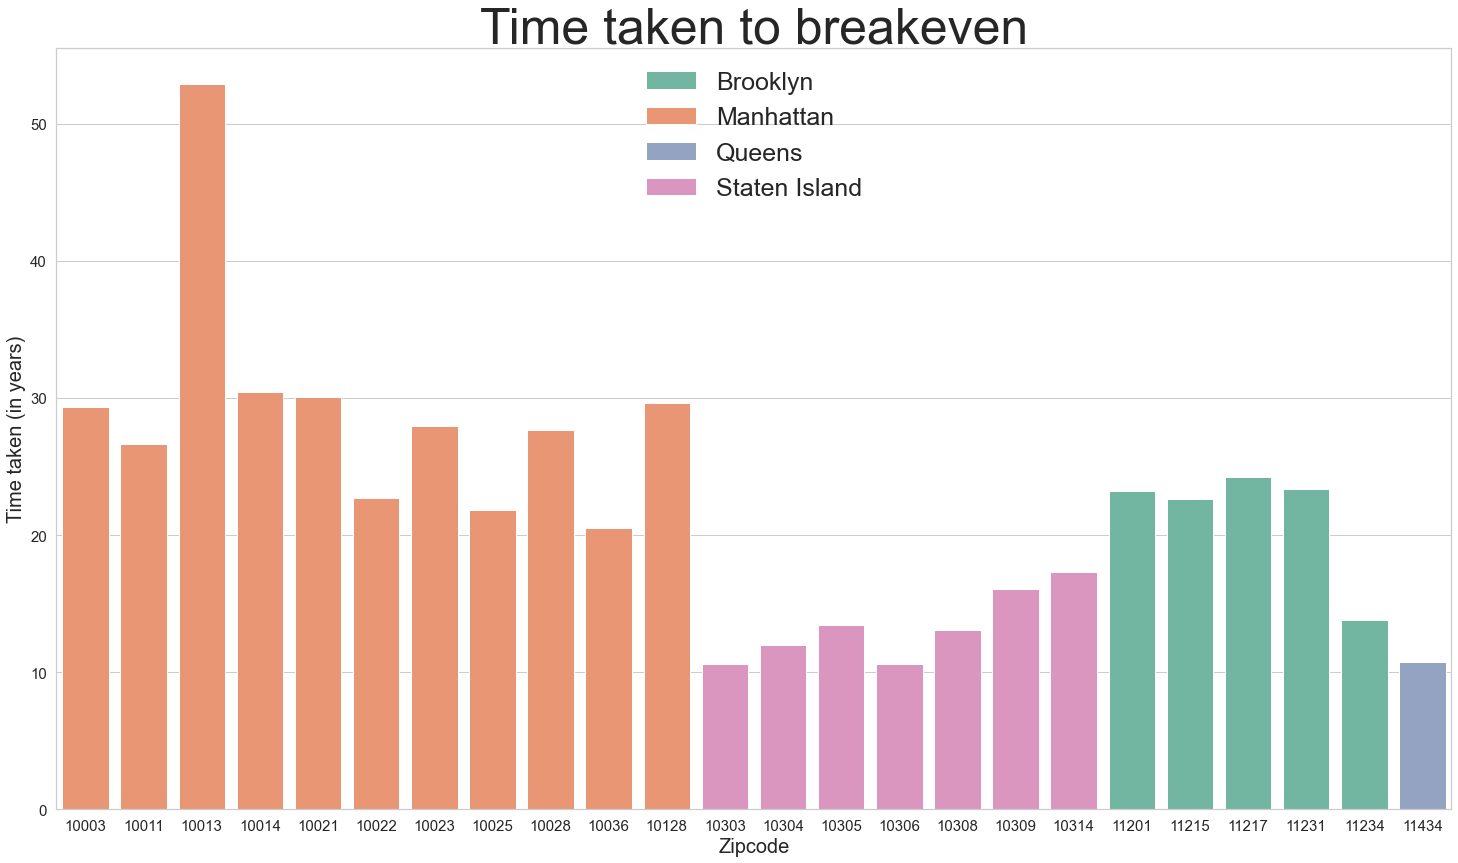

In [65]:
plt.rcParams['figure.figsize'] = [25, 14]
sns.set(style="whitegrid")
df=airbnb_breakeven_df.groupby(['zipcode','neighbourhood_group_cleansed'])['years'].median().to_frame().reset_index()
ax = sns.barplot(x="zipcode", y="years", data=df,hue='neighbourhood_group_cleansed',dodge=False, palette = 'Set2')
plt.xlabel('Zipcode', fontsize=20)
plt.ylabel('Time taken (in years)', fontsize=20)
ax.axes.set_title("Time taken to breakeven",fontsize=50)
ax.legend(fontsize=25)
for tick in ax.axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax.axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

We see that properties in Manahattan and Brooklyn take longer to breakeven irrespective of high median price. This is because of higher cost in investment. Staten Island and Queens take relatively lesser number of years to breakeven and start making profits thereafter.


#### Calculating the metrics
Popularity of zipcodes can be determined based on the following factors:

% Annual Return On Investment (ROI): This is going to be our key quantitaive metric for the decision. It will be calculated as: (Annual Return (including 75% occupancy rate) per year / Total investment) * 100

Next we can look at some qualitative factors that drive occupancy:

Demand: Count of airbnb properties for each zipcode
Popularity: Count of reviews received by each property, grouped by each zipcode
Availability: Number of days the property is available in the next 365 days, summed over each zipcode
Methodology for score calculation
A weight is assigned each of the 4 metrics. The ROI metric is assigned the highest weight of 40% and the rest of the metrics are each assigned a weight of 20%
Within each metric, a rank score is assigned for the top 5 zipcodes. First ranked zipcode receives a score of 50, second zipcode a score of 40 and so on till the 5th ranked zipcode
All 4 metric dataframes are combined and the scores for each zipcode are summed up to get the total score?

In [66]:
#function to calculate the metrics and score for each zipcode
def roi(df):
    #Define weight arrays for each metric
    rank_score = [50, 40, 30, 20, 10]
    weight_quant = [0.40, 0.40, 0.40, 0.40, 0.40]
    weight_qual = [0.20, 0.20, 0.20, 0.20, 0.20]
        
    #Calculate median rent per night for each zip code
    roi_data = df[['zipcode', 'price', 'Median_Price']].copy()
    roi_data = roi_data.groupby(['zipcode', 'Median_Price'])['price'].median().reset_index()
    roi_data = roi_data.rename(columns = {'price': 'Median rent per night'})
    
    #Calculate % annual ROI
    roi_data['Annual ROI(%)'] = ((roi_data['Median rent per night']*365*0.75)/(roi_data['Median_Price']))*100
    roi_data = roi_data.nlargest(5, 'Annual ROI(%)')
    print(roi_data, '\n')
    roi_data['ROI Score'] = [a * b for a, b in zip(rank_score, weight_quant)]
    metric_roi = roi_data.drop(['Median_Price', 'Median rent per night', 'Annual ROI(%)'], axis = 1)
    
    #Get top zipcodes based on demand
    df_demand = df['zipcode'].value_counts().reset_index().rename(columns = {'index':'zipcode','zipcode':'Property count'}).nlargest(5, 'Property count')
    print(df_demand, '\n')
    df_demand['Demand Score'] = [a * b for a, b in zip(rank_score, weight_qual)]
    metric_demand = df_demand.drop('Property count', axis = 1)
    
    #Get top zipcodes based on popularity
    df_popularity = df.groupby(['zipcode', 'neighbourhood_group_cleansed'])['number_of_reviews'].sum().reset_index()
    df_popularity = df_popularity.sort_values(by = 'number_of_reviews').nlargest(5, 'number_of_reviews')
    print(df_popularity, '\n')
    df_popularity['Popularity Score'] = [a * b for a, b in zip(rank_score, weight_qual)]
    metric_popularity = df_popularity.drop(['neighbourhood_group_cleansed', 'number_of_reviews'], axis = 1)
    
    #Get top zipcodes based on availability
    df_availability = df.groupby(['zipcode', 'neighbourhood_group_cleansed'])['availability_365'].sum().reset_index().sort_values(by = 'availability_365', ascending = True)
    df_availability = df_availability.iloc[0:5,]
    print(df_availability, '\n')
    df_availability['Availability Score'] = [a * b for a, b in zip(rank_score, weight_qual)]
    metric_availability = df_availability.drop(['neighbourhood_group_cleansed', 'availability_365'], axis = 1)
    
    #Join all metrics dataframes into one and replace NaNs with zero
    metrics = pd.concat([metric_roi,metric_demand, metric_popularity, metric_demand],axis = 0)
    metrics[['Demand Score', 'Popularity Score', 'ROI Score']] = metrics[['Demand Score', 'Popularity Score', 'ROI Score']].fillna(value=0)
    
    #Calculate sum of all scores for each zipcode and return the top 5 profitable zipcodes
    metrics = metrics.groupby('zipcode').sum().reset_index()
    metrics['Total Score'] = metrics['Demand Score'] + metrics['ROI Score'] + metrics['Popularity Score']
    metrics = metrics.sort_values(by = 'Total Score').nlargest(5, 'Total Score')
    
    return metrics

In [67]:
metrics = roi(df_merge)

    zipcode  Median_Price  Median rent per night  Annual ROI(%)
338   10306      341250.0                  117.5       9.425824
265   10303      312450.0                  107.5       9.418507
556   11434      373950.0                  127.0       9.297032
288   10304      311050.0                   95.0       8.360794
366   10308      392100.0                  109.5       7.644893 

  zipcode  Property count
0   11215             189
1   10036             147
2   10003             136
3   11217             124
4   10025             124 

   zipcode neighbourhood_group_cleansed  number_of_reviews
76   11215                     Brooklyn             5695.0
1    10003                    Manhattan             3247.0
80   11217                     Brooklyn             2794.0
37   10036                    Manhattan             2739.0
84   11231                     Brooklyn             2456.0 

   zipcode neighbourhood_group_cleansed  availability_365
67   10309                Staten Island   

#### Based on the metrics defined above, here are the 5 most profitable zip codes in NYC

In [68]:
metrics.reset_index().drop('index', axis = 1)

,zipcode,ROI Score,Demand Score,Popularity Score,Total Score
0,11215,0.0,20.0,10.0,30.0
1,10306,20.0,0.0,0.0,20.0
2,10036,0.0,16.0,4.0,20.0
3,10003,0.0,12.0,8.0,20.0
4,10303,16.0,0.0,0.0,16.0


#### From the above analysis,the following zipcodes are the most profitable to invest;
11215 - Brooklyn

10306 - Manhattan

10036 - Manhattan

10003 - Manhattan

10303 - Staten Island

### Future Work 

#### Occupancy Rate

We have assumed an occupancy rate of 75%. We shall need to determine the median occupancy rate of each zipcode by analyzing bookings data. By analyzing this data and plugging the occupancy rate into the breakeven formula, we can suggest a more accurate recommendation.

#### Cost of Property

We are calculating this based on the cost of property in 2017. We need access to cost of properties in 2019 and run through the analysis again to observe if our observation holds true.

#### Type of property

Our recommendation is based on the median price of properties irrespective of room-type. We see a massive difference in median price between room-types. We shall need to execute this analysis again by recommending zipcodes for each room-type

#### Brand Value

Determine if the investors are looking for marketing and branding advantages. Since Manhattan and Brooklyn are popular and busy, even if they pose a higher risk and higher capital investment, having an airbnb in these areas might increase the brand value of the investor. With this knowledge, it will help us make a better call in recommending best zipcodes to invest in.

#### Square Feet

The data had 99% missing values in the square feet column. From the correlation plot, we determined that the square feet feature has a huge influence of price. If we can obtain data regarding sq.feet values of all two bedroom listings, we can bin sq.footage into categories and recommend more zipcodes for each bin.